In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import os

# import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10

from Funciones import *

In [2]:
def graf_cross_val(model, X_train, y_train, cv, scorings=['accuracy'], path = './', name = 'Figura.png'):
    
    for scoring in scorings:

        results = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        if scoring.split('_')[0]=='neg':
            results = -np.array(results)
            scoring = scoring[4:]
        else:
            results = np.array(results)
        print(results)
        print(results.mean())


        plt.figure(figsize=(3,3))
        plt.plot(np.arange(1,len(results)+1), results)
        plt.xlabel('Validación cruzada')
        plt.ylabel(scoring)
        plt.ylim([0,1])
        plt.savefig(path+name.replace('.png', f'_{scoring}.png'), bbox_inches='tight', dpi=150)
        
def graf_learning_curve(model, X_train, y_train, cv, scorings,  path = './', name = 'Figura.png'):
    
    for scoring in scorings:

        lc = learning_curve(model,X_train, y_train, cv=cv, scoring=scoring)
    
        if scoring.split('_')[0]=='neg':
            train_sizes, train_scores, test_scores = lc[0], -lc[1], -lc[2]
            scoring = scoring[4:]
        else:
            train_sizes, train_scores, test_scores = lc[0], lc[1], lc[2]

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(5,5))
        plt.title("Curva de aprendizaje")    
        plt.xlabel("Muestras")
        plt.ylabel(scoring)
        plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label = f"{scoring} entrenamiento")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label=f"{scoring} validación")
#         plt.ylim([0.5,1])
        plt.legend(loc="best");
        plt.savefig(path+name.replace('.png', f'_{scoring}.png'), bbox_inches='tight', dpi=150)

In [3]:
ruta_base  = os.path.dirname(os.path.abspath('./')) + '/'
ruta_datos = ruta_base + 'Datos/'
ruta_shp   = ruta_datos+ 'Shapefiles/'
ruta_imagenes = ruta_base + 'Imagenes/'

In [4]:
# Carga información
datos_pcs = pd.read_csv(ruta_datos+'Datos_PCS.csv', index_col=0, parse_dates=True)

In [5]:
# pcs utilizadas
pcs_util =  ['PC1', 'PC2', 'PC18', 'PC9', 'PC6', 'PC16', 'PC7', 'PC8', 'Caudal']

datos_pcs = datos_pcs[pcs_util]

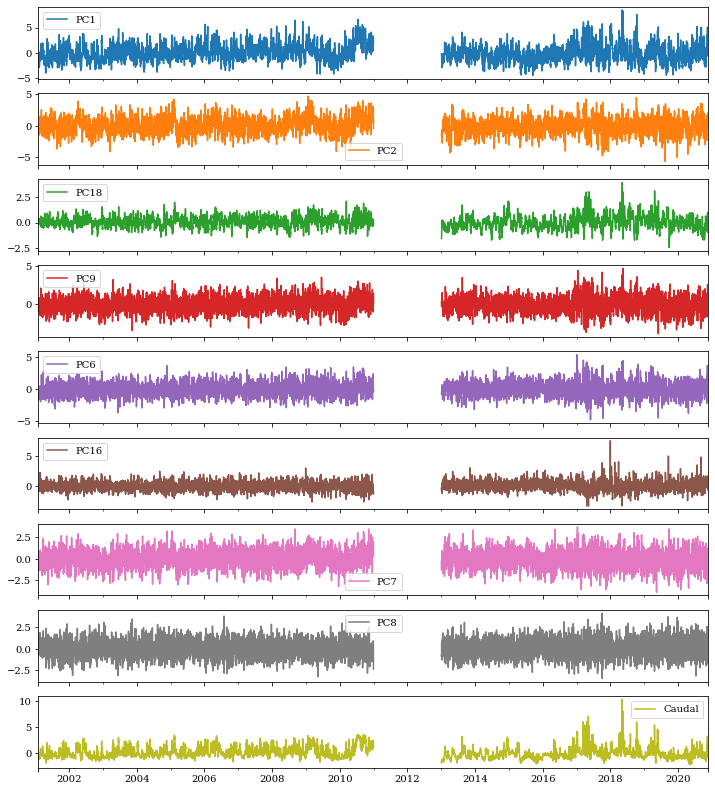

In [6]:
pcs_y_gra = datos_pcs.copy()
pcs_y_gra = pcs_y_gra.asfreq('D')
pcs_y_gra.plot(subplots=True, figsize=(12,14))
plt.savefig(ruta_imagenes+'Series_PCs_regresion.png', bbox_inches='tight', dpi=150)

### Datos de calibración y validación

In [7]:
X = datos_pcs.drop(['Caudal'],axis=1)
y = datos_pcs['Caudal']

In [8]:
f_train = '2016-12-31'
f_test  = '2017-01-01'

X_train = X[:f_train]
X_test  = X[f_test:]

y_train = y[:f_train]
y_test  = y[f_test:]

kfold = KFold(n_splits=5, shuffle= False)

## Regresión lineal

### Evaluación de la regularización

In [10]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

### Tipo Ridge

In [26]:
rr001 = Ridge(alpha=0.01)
rr001.fit(X_train, y_train)
Ridge_score_001 = rr001.score(X_test,y_test)
print('Ridge score_001:', Ridge_score_001)

rr = Ridge()
rr.fit(X_train, y_train)
Ridge_score = rr.score(X_test,y_test)
print('Ridge score_1:', Ridge_score)

rr100 = Ridge(alpha=100)
rr100.fit(X_train, y_train)
Ridge_score_100 = rr100.score(X_test,y_test)
print('Ridge score_100:', Ridge_score_100)

Ridge score_001: 0.5446993952908898
Ridge score_1: 0.5447033019051073
Ridge score_100: 0.5446324883299365


In [27]:
# rr001 = Ridge(alpha=0.01)
# rr001.fit(X_train, y_train)
# Ridge_score_001 = rr001.score(X_train,y_train)
# print('Ridge score_001:', Ridge_score_001)

# rr = Ridge()
# rr.fit(X_train, y_train)
# Ridge_score = rr.score(X_train,y_train)
# print('Ridge score_1:', Ridge_score)

# rr100 = Ridge(alpha=100)
# rr100.fit(X_train, y_train)
# Ridge_score_100 = rr100.score(X_train,y_train)
# print('Ridge score_100:', Ridge_score_100)

Los cambios no son significativos

### Tipo Lasso

In [28]:
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train, y_train)
lasso_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("Lasso score para alpha=0.01 es", lasso_score001) 
# print ("Número de variables utilizadas para alpha =0.01:", coeff_used001)
# print(lasso001.coef_)

lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_score_1=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print ("Lasso score para alpha=1 es", lasso_score_1) 
# print ("Número de variables utilizadas para alpha =1: ", coeff_used)
# print(lasso.coef_)

lasso100 = Lasso(alpha=100, max_iter=10e5)
lasso100.fit(X_train, y_train)
lasso_score100=lasso100.score(X_test,y_test)
coeff_used100 = np.sum(lasso100.coef_!=0)
print ("Lasso score para alpha=100 es", lasso_score100) 
# print ("Número de variables utilizadas para alpha =100:", coeff_used100)
# print(lasso100.coef_)

Lasso score para alpha=0.01 es 0.5436434909619119
Lasso score para alpha=1 es 0.00829605956120505
Lasso score para alpha=100 es -0.0017952946225268107


La mejor es la regresión lineal normal

In [41]:
matriz_regresion = pd.DataFrame(index = ['Rigde', 'Lasso'], data = np.array([[Ridge_score_001, Ridge_score, Ridge_score_100],[lasso_score001,lasso_score_1,lasso_score100]]),
                                       columns=['0.01','1','100'])

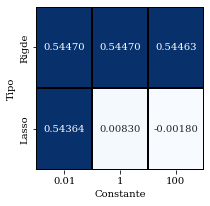

In [44]:
plt.figure(figsize=(3,3))
sns.heatmap(matriz_regresion, annot=True,  fmt='.5f', cbar=False, linecolor='black', linewidths=0.7,cmap=plt.cm.Blues)
plt.xlabel('Constante')
plt.ylabel('Tipo')
plt.savefig(ruta_imagenes+'Regulacion.png', bbox_inches='tight', dpi=150)

### Regresion lineal normal

In [45]:
lr = LinearRegression()

[0.63312091 0.62553498 0.64727719 0.82585842 0.65813217]
0.6779847350079612
[0.2275126  0.26066963 0.31210543 0.25493877 0.2063849 ]
0.2523222665329604


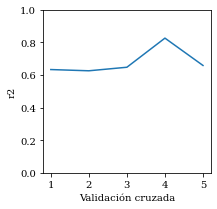

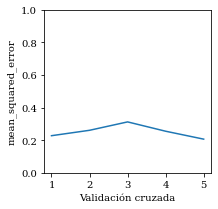

In [48]:
# Validación cruzada
graf_cross_val(model=lr, X_train=X_train, y_train=y_train, cv=kfold, scorings=['r2','neg_mean_squared_error'], path = ruta_imagenes, name = 'R_LR_CV.png') # make_scorer(r2_score), make_scorer(mean_squared_error)

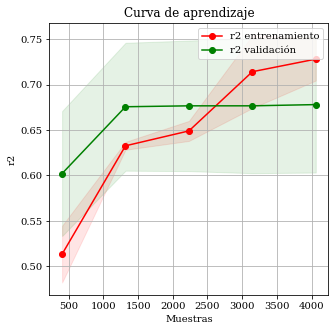

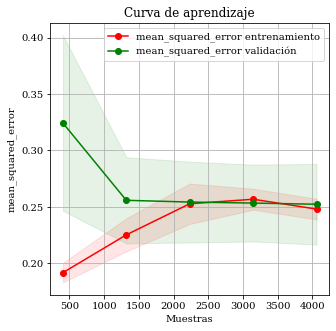

In [49]:
# Cruva de aprendizaje
graf_learning_curve(model=lr, X_train=X_train, y_train=y_train, cv=kfold, scorings=['r2','neg_mean_squared_error'], path = ruta_imagenes, name = 'R_LR_LC.png')

### Significancia de la regresión

In [41]:
import statsmodels.api as sm
X_train_constant = sm.add_constant(X_train)
lm=sm.OLS(y_train, X_train_constant).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 Caudal   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1717.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:25:11   Log-Likelihood:                -3670.4
No. Observations:                5077   AIC:                             7359.
Df Residuals:                    5068   BIC:                             7418.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0306      0.007     -4.366      0.0

In [54]:
names = []
scores = []
predicciones = []

In [55]:
model=lr.fit(X_train,y_train)
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

names.append('LR')
scores.append([r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)])
predicciones.append(y_test_pred)
print(r2_score(y_test, y_test_pred))
print(mean_squared_error(y_test, y_test_pred))

0.5446993553013442
0.672010848615313


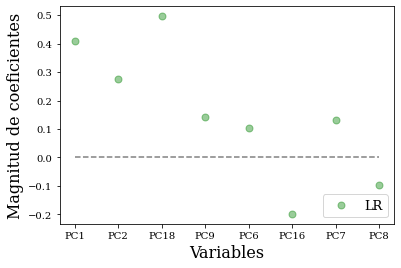

In [59]:
plt.plot(np.arange(1,9), model.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='LR')
plt.xlabel('Variables',fontsize=16)
plt.ylabel('Magnitud de coeficientes',fontsize=16)
plt.hlines(xmin=1, xmax=8, y=0, ls='--', color='gray')
plt.xticks(np.arange(1,9), X.columns)
plt.legend(fontsize=13,loc=4)
plt.show()

### Verifiquemos las suposiciones de la regresión

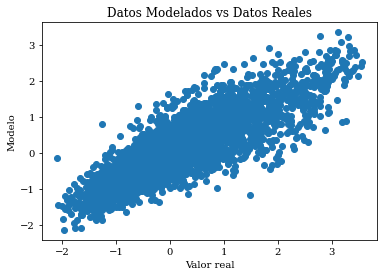

In [60]:
plt.scatter(y_train, y_train_pred)
plt.title('Datos Modelados vs Datos Reales')
plt.xlabel('Valor real')
plt.ylabel('Modelo');
plt.savefig(ruta_imagenes+'pron_reales_train.png', bbox_inches='tight', dpi=150)

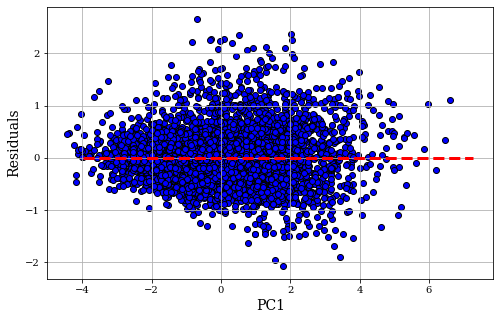

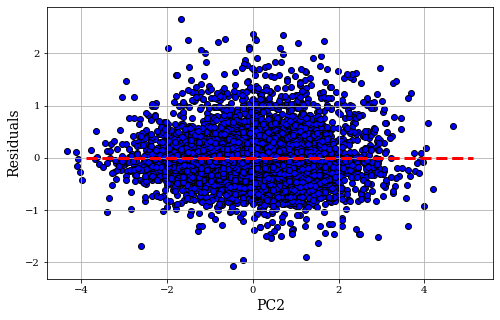

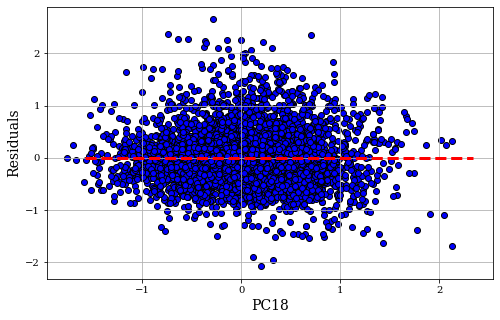

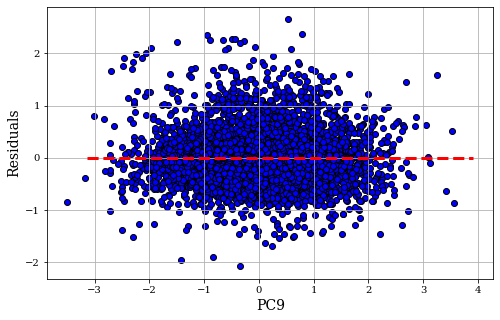

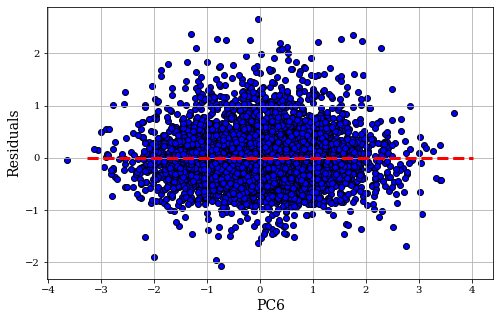

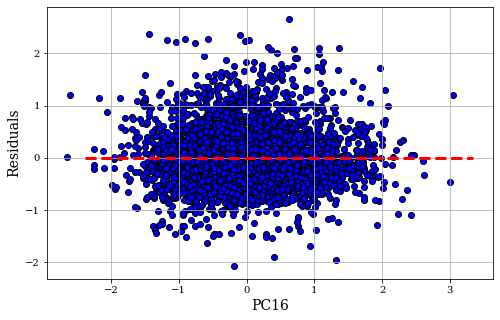

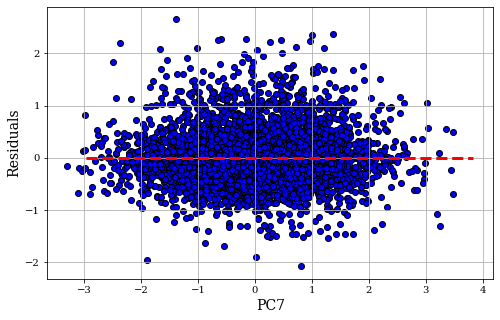

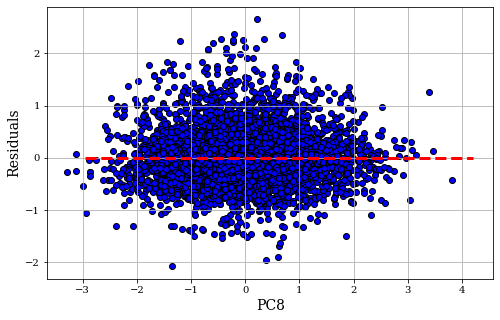

In [62]:
# Analisis de residuales
residuales = y_train-y_train_pred

for x in X_train:
    pc = X_train[x]
    plt.figure(figsize=(8,5))
    plt.scatter(x=pc,y=residuales,color='blue',edgecolor='k')
    plt.grid(True)
    xmin=min(pc)
    xmax = max(pc)
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.ylabel('Residuals',fontsize=14)
    plt.xlabel(x,fontsize=14)
    plt.show()


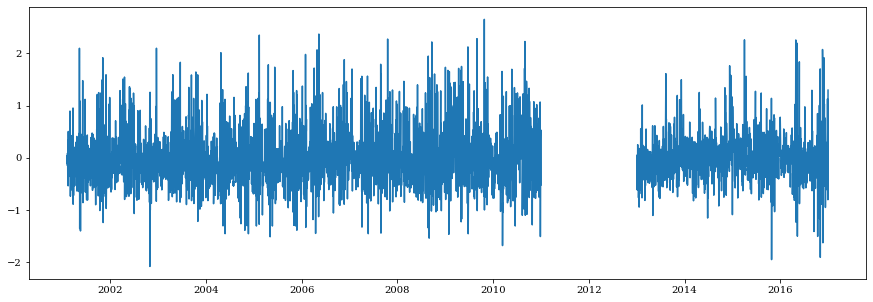

In [63]:
plt.figure(figsize=(15,5))
plt.plot(residuales.asfreq('D'))

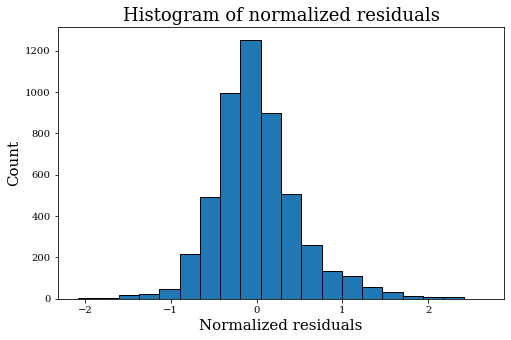

In [65]:
plt.figure(figsize=(8,5))
plt.hist(residuales,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.savefig(ruta_imagenes+'hist_residuales_train.png', bbox_inches='tight', dpi=150)

<Figure size 576x360 with 0 Axes>

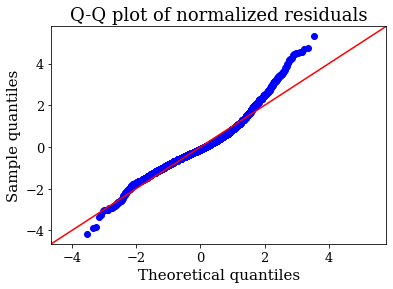

In [66]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(8,5))
fig=qqplot(residuales,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
# plt.grid(True)
plt.show()

In [67]:
from scipy.stats import shapiro
_,p=shapiro(residuales)
if p<0.05:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")

The residuals seem to come from Gaussian process


In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
for i in range(X_train.shape[1]):
    v=vif(np.matrix(X_train),i)
    print("Variance inflation factor for x{}: {}".format([i+1],round(v,2)))

Variance inflation factor for x[1]: 1.0
Variance inflation factor for x[2]: 1.0
Variance inflation factor for x[3]: 1.0
Variance inflation factor for x[4]: 1.0
Variance inflation factor for x[5]: 1.0
Variance inflation factor for x[6]: 1.0
Variance inflation factor for x[7]: 1.0
Variance inflation factor for x[8]: 1.0


# Vecino más cercano  (KNN)

### Evaluación de hiperparametros

In [69]:
#Hiperparametros a evaluar.
leaf_size = [1]
n_neighbors = list(range(1,50))
p=[1]

#Realizar un diccionario con los valores a evaluar.
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

In [70]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor

knn_2 = KNeighborsRegressor()
clf = GridSearchCV(knn_2, hyperparameters, cv=kfold, scoring='r2')
best_model = clf.fit(X_train,y_train)
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 21


In [71]:
KNN = KNeighborsRegressor(n_neighbors=21, leaf_size=1, p=1)

[0.57944207 0.58442156 0.55213406 0.695349   0.5022471 ]
0.5827187567751166
[0.26080044 0.28928918 0.39629246 0.4460012  0.3004924 ]
0.3385751361901256


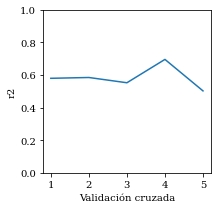

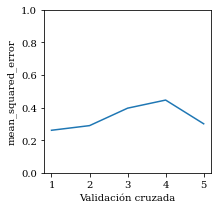

In [72]:
# Validación cruzada
graf_cross_val(model=KNN, X_train=X_train, y_train=y_train, cv=kfold, scorings=['r2','neg_mean_squared_error'], path = ruta_imagenes, name = 'R_KNN_CV.png') # make_scorer(r2_score), make_scorer(mean_squared_error)

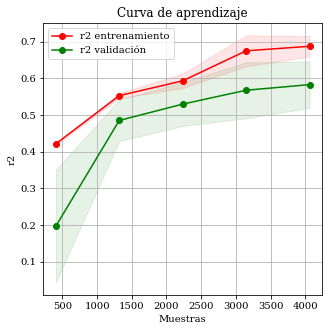

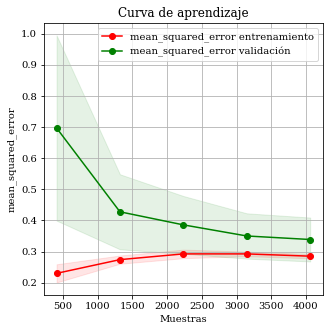

In [73]:
# Cruva de aprendizaje
graf_learning_curve(model=KNN, X_train=X_train, y_train=y_train, cv=kfold, scorings=['r2','neg_mean_squared_error'], path = ruta_imagenes, name = 'R_KNN_LC.png')

In [75]:
model=KNN.fit(X_train,y_train)
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

names.append('KNN')
scores.append([r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)])
predicciones.append(y_test_pred)
print(r2_score(y_test, y_test_pred))
print(mean_squared_error(y_test, y_test_pred))

0.47225722556027017
0.7789333791446081


In [76]:
scores

[[0.5446993553013442, 0.672010848615313],
 [0.47225722556027017, 0.7789333791446081]]

# Suport Vector Maching (SVM)

### Evaluación de hiperparametros

In [78]:
#Hiperparametros a evaluar.
C = np.linspace(0.01, 10, 4)
gamma = np.linspace(0.01, 10, 4)
kernel = ['linear', 'rbf']

#Realizar un diccionario con los valores a evaluar.
hyperparameters = dict(C = C, gamma=gamma, kernel=kernel)

In [79]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
svr_2 = SVR()
clf = GridSearchCV(svr_2, hyperparameters, cv=kfold, scoring='r2')
best_model = clf.fit(X_train,y_train)
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best gamma:', best_model.best_estimator_.get_params()['gamma'])
print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])

Best C: 6.67
Best gamma: 0.01
Best kernel: linear


In [81]:
from sklearn.svm import SVR
svr = SVR(C=6.67, gamma=0.01, kernel='linear') #C=, gamma=, kernel=

[0.63246973 0.62632077 0.6339287  0.81898829 0.65894844]
0.6741311874446851
[0.22791641 0.26012264 0.32391679 0.26499646 0.20589212]
0.2565688838003912


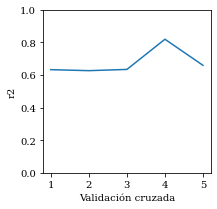

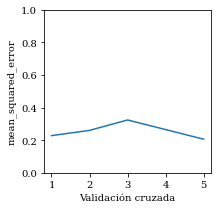

In [82]:
# Validación cruzada
graf_cross_val(model=svr, X_train=X_train, y_train=y_train, cv=kfold, scorings=['r2','neg_mean_squared_error'], path = ruta_imagenes, name = 'R_SVR_CV.png') # make_scorer(r2_score), make_scorer(mean_squared_error)

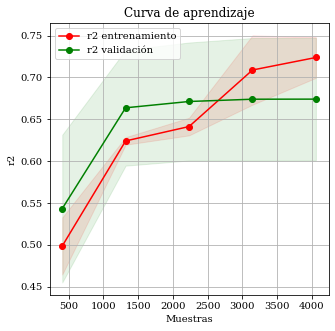

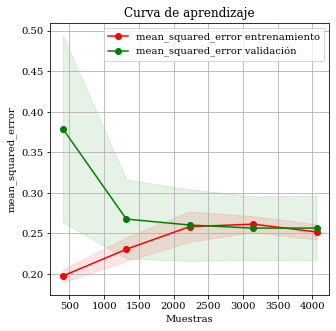

In [89]:
# Cruva de aprendizaje
graf_learning_curve(model=svr, X_train=X_train, y_train=y_train, cv=kfold, scorings=['r2','neg_mean_squared_error'], path = ruta_imagenes, name = 'R_SVR_LC.png')

In [83]:
model=svr.fit(X_train,y_train)
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

names.append('SVR')
scores.append([r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)])
predicciones.append(y_test_pred)
print(r2_score(y_test, y_test_pred))
print(mean_squared_error(y_test, y_test_pred))

0.5379684392086946
0.6819454900177508


In [93]:
predicciones

[array([1.21797859, 2.26973447, 1.92229202, ..., 1.2127173 , 0.89437748,
        1.1489855 ]),
 array([1.62571831, 2.02873005, 1.28200864, ..., 1.16506932, 0.59449094,
        1.01940696]),
 array([1.07332385, 2.20178442, 1.85772578, ..., 1.07252153, 0.81954207,
        1.11194012])]

# Redes neuronales artificiales

In [94]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(early_stopping=True, shuffle=False, activation = 'tanh') #hidden_layer_sizes=(5,4,2)

### Evaluación de hiperparametros

In [34]:
#Hiperparametros a evaluar.

capa_1 = np.arange(10,51,10)
capa_2 = np.arange(10,51,10)
capa_3 = np.arange(10,51,10)

capas = []
for c1 in capa_1:
    for c2 in capa_2:
        for c3 in capa_3:
            capas.append(tuple((c1,c2,c3)))
            
hidden_layer_sizes = capas

#Realizar un diccionario con los valores a evaluar.
hyperparameters = dict(hidden_layer_sizes=hidden_layer_sizes)

In [35]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
clf = GridSearchCV(mlp, hyperparameters, cv=kfold, scoring='r2')
best_model = clf.fit(X_train,y_train)
print('Best hidden_layer_sizes:', best_model.best_estimator_.get_params()['hidden_layer_sizes'])

Best hidden_layer_sizes: (40, 30, 30)


In [95]:
# Mejor red neuronal
mlp = MLPRegressor(hidden_layer_sizes=(10,10,50), early_stopping=True, shuffle=False, activation = 'tanh')
# mlp = MLPRegressor(hidden_layer_sizes=(40,30,30), early_stopping=True, shuffle=False, activation = 'tanh')

[0.62476926 0.61036119 0.63762603 0.79998819 0.66139583]
0.6668281015114944
[0.23425986 0.26999314 0.32293498 0.28064091 0.20722034]
0.26300984494626495


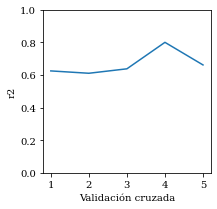

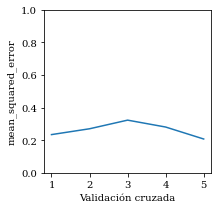

In [96]:
# Validación cruzada
graf_cross_val(model= mlp, X_train=X_train, y_train=y_train, cv=kfold, scorings=['r2','neg_mean_squared_error'], path = ruta_imagenes, name = 'R_MLP_CV.png') # make_scorer(r2_score), make_scorer(mean_squared_error)

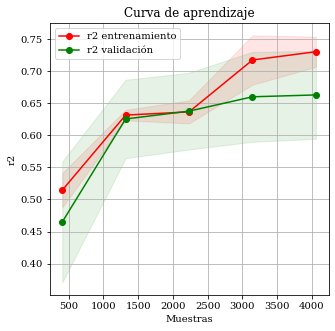

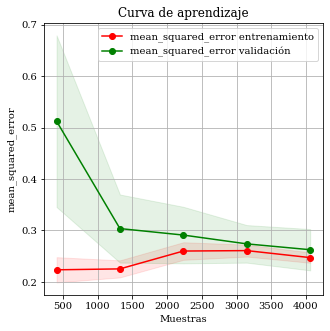

In [97]:
# Cruva de aprendizaje
graf_learning_curve(model=mlp, X_train=X_train, y_train=y_train, cv=kfold, scorings=['r2','neg_mean_squared_error'], path = ruta_imagenes, name = 'R_MLP_LC.png')

In [98]:
mlp.fit(X_train,y_train)
y_test_pred = mlp.predict(X_test)
y_train_pred = mlp.predict(X_train)

names.append('MLP')
scores.append([r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)])
predicciones.append(y_test_pred)
print(r2_score(y_test, y_test_pred))
print(mean_squared_error(y_test, y_test_pred))

0.5508444387037368
0.662940879661531


In [104]:
names

['LR', 'KNN', 'SVR', 'MLP']

# Random forest 

In [100]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
rf = RandomForestRegressor()
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Elección de hiperparametros

In [52]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [53]:
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='r2', 
                              cv = kfold, verbose=2, random_state=1, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  36.6s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=  25.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=  37.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 1.9min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1400; total time=  27.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   7.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimator

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 1.0min[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  26.2s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=  26.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=  16.8s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  11.4s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  11.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 2.0min
[CV] END bootstrap=False, max_depth=20, m

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  17.3s[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  25.8s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=  25.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=  16.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=  38.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  22.4s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  22.7s
[CV] END bootstrap=False, max_depth=40, 

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time= 1.9min[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  25.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  40.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=  39.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  23.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=False, max_de

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, scoring='r2', verbose=2)

In [58]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [101]:
# Mejor random forest
rf = RandomForestRegressor(n_estimators= 800, min_samples_split = 2, min_samples_leaf= 2,
 max_features = 'auto',  max_depth = 100,  bootstrap= True)

[0.59968031 0.58837689 0.60441637 0.76345598 0.5756439 ]
0.6263146904976089
[0.24899544 0.28669791 0.35375661 0.34981558 0.25621494]
0.29909609431135675


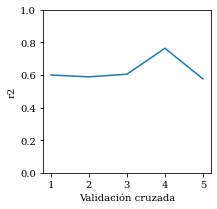

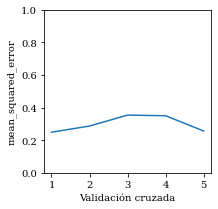

In [102]:
# Validación cruzada
graf_cross_val(model= rf, X_train=X_train, y_train=y_train, cv=kfold, scorings=['r2','neg_mean_squared_error'], path = ruta_imagenes, name = 'R_RF_CV.png') # make_scorer(r2_score), make_scorer(mean_squared_error)

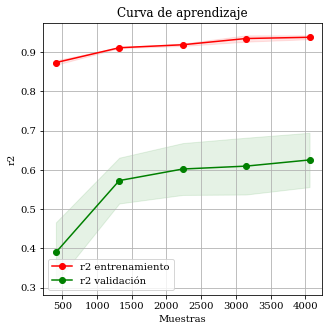

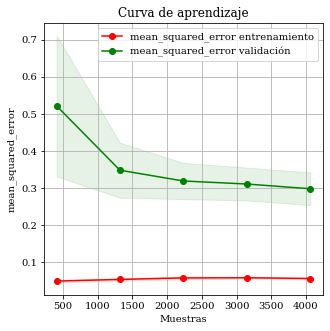

In [103]:
# Cruva de aprendizaje
graf_learning_curve(model=rf, X_train=X_train, y_train=y_train, cv=kfold, scorings=['r2','neg_mean_squared_error'], path = ruta_imagenes, name = 'R_RF_LC.png')

In [105]:
rf.fit(X_train,y_train)

y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

names.append('RF')
scores.append([r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)])
predicciones.append(y_test_pred)
print(r2_score(y_test, y_test_pred))
print(mean_squared_error(y_test, y_test_pred))

0.4906847683742791
0.7517348481771563


# Guardar datos hasta el momento

In [109]:
# pd.DataFrame(index=names, data = predicciones).to_csv('predicciones.csv')

In [110]:
# pd.DataFrame(index=names, data = scores).to_csv('scores.csv')

# Leer archivos

In [24]:
names = list(pd.read_csv('scores.csv', index_col=0).index)
scores = list(pd.read_csv('scores.csv', index_col=0).values)
predicciones = list(pd.read_csv('predicciones.csv', index_col=0).values)

# SARIMAX

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model import yule_walker

In [27]:
model = SARIMAX(y_train['2013-01-01':].asfreq('D'), X_train['2013-01-01':].asfreq('D'), order=(2,0,1), seasonal_order=(0,0,0,0), simple_differencing=False)
history=model.fit()
history.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28980D-01    |proj g|=  1.24210D-01


 This problem is unconstrained.



At iterate    5    f=  5.25804D-01    |proj g|=  1.11583D-02

At iterate   10    f=  5.25669D-01    |proj g|=  1.98889D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     13     16      1     0     0   7.695D-05   5.257D-01
  F =  0.52566879292314550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Caudal   No. Observations:                 1459
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -766.951
Date:                Wed, 07 Dec 2022   AIC                           1557.902
Time:                        11:41:15   BIC                           1621.328
Sample:                    01-03-2013   HQIC                          1581.563
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1            0.3637      0.010     34.764      0.000       0.343       0.384
PC2            0.2682      0.012     23.168      0.000       0.245       0.291
PC18           0.5573      0.026     21.729      0.000       0.507       0.608
PC9            0.1576      0.012     12.991      0.000       0.134       0.181
PC6            0.1363      0.014     10.089      0.000       0.110       0.163
PC16          -0.2359      0.016    -15.118      0.000      -0.266      -0.205
PC7            0.1460      0.011     13.575      0.000       0.125       0.167
PC8           -0.0861      0.011     -7.842      0.000      -0.108      -0.065
ar.L1         -0.3012      3.438     -0.088      0.930      -7.041       6.438
ar.L2          0.1082      0.760      0.142      0.887      -1.381       1.597
ma.L1          0.5189      3.442      0.151      0.880      -6.227       7.264
sigma2         0.1675      0.004     45.622      0.000       0.160       0.175
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              1665.33
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
from typing import Union
from tqdm import tqdm_notebook
from itertools import product

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list],order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
            endog,
            exog,
            order=(order[0], d, order[1]),
            seasonal_order=(order[2], D, order[3], s),
            simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, model.aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df

In [29]:
# p = range(0, 4, 1)
# d = 1
# q = range(0, 4, 1)
# P = range(0, 4, 1)
# D = 0
# Q = range(0, 4, 1)
# s = 0
# parameters = product(p, q, P, Q)
# parameters_list = list(parameters)

# result_df = optimize_SARIMAX(y_train['2013-01-01':].asfreq('D'), X_train['2013-01-01':].asfreq('D'), parameters_list, d, D, s)
# result_df

In [30]:
# history.predict(start=5000,end=7000).plot()
y_test_pred = history.predict(exog = X_test, start = y_test.index[0], end = y_test.index[-1], dinamical=True)

In [32]:
# names.append('SARIMAX')
scores[5] = [r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)]
predicciones[5] = y_test_pred.values
print(r2_score(y_test, y_test_pred))
print(mean_squared_error(y_test, y_test_pred))

0.5457221212029917
0.6705012751290822


In [31]:
names

['LR', 'KNN', 'SVR', 'MLP', 'RF', 'SARIMAX', 'LSTM']

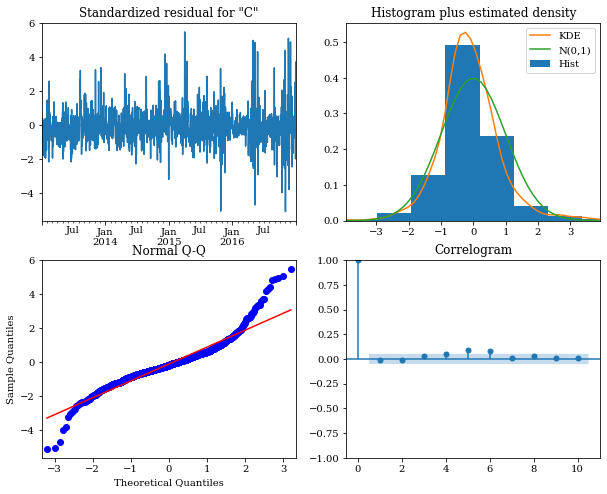

In [34]:
history.plot_diagnostics(figsize=(10,8));
plt.savefig(ruta_imagenes+'diagnostico_sarimax.png', bbox_inches='tight', dpi=150)

In [35]:
# pd.DataFrame(index=names, data = predicciones).to_csv('predicciones.csv')

In [36]:
# pd.DataFrame(index=names, data = scores).to_csv('scores.csv')

# Long Short Term Memory (redes recurrentes)

In [37]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM

In [45]:
lstm_model = Sequential()
lstm_model.add(LSTM(10, input_shape = (X_train.shape[1],1), return_sequences=True, activation ='relu'))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(10,activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(50,activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(1))
lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])

In [46]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8, 10)             480       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 10)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 8, 10)             840       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 10)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total para

In [47]:
lstm_model.fit(np.atleast_3d(X_train), y_train, epochs=50, batch_size=100, validation_split=0.1)

Train on 4569 samples, validate on 508 samples
Epoch 1/50
4569/4569 [==============================] - 8s 2ms/sample - loss: 0.8544 - mean_squared_error: 0.8544 - val_loss: 0.3773 - val_mean_squared_error: 0.3773
Epoch 2/50
4569/4569 [==============================] - 4s 947us/sample - loss: 0.4419 - mean_squared_error: 0.4419 - val_loss: 0.3349 - val_mean_squared_error: 0.3349
Epoch 3/50
4569/4569 [==============================] - 4s 935us/sample - loss: 0.3506 - mean_squared_error: 0.3506 - val_loss: 0.3073 - val_mean_squared_error: 0.3073
Epoch 4/50
4569/4569 [==============================] - 4s 939us/sample - loss: 0.3472 - mean_squared_error: 0.3472 - val_loss: 0.3390 - val_mean_squared_error: 0.3390
Epoch 5/50
4569/4569 [==============================] - 4s 935us/sample - loss: 0.3384 - mean_squared_error: 0.3384 - val_loss: 0.3426 - val_mean_squared_error: 0.3426
Epoch 6/50
4569/4569 [==============================] - 5s 1ms/sample - loss: 0.3378 - mean_squared_error: 0.3378 -

4569/4569 [==============================] - 4s 856us/sample - loss: 0.3188 - mean_squared_error: 0.3188 - val_loss: 0.3261 - val_mean_squared_error: 0.3261
Epoch 50/50
4569/4569 [==============================] - 4s 831us/sample - loss: 0.3221 - mean_squared_error: 0.3221 - val_loss: 0.3365 - val_mean_squared_error: 0.3365


In [48]:
y_test_pred = lstm_model.predict(np.atleast_3d(X_test))
y_train_pred = lstm_model.predict(np.atleast_3d(X_train))

# names.append('LSTM')
scores[6] = [r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)]
predicciones[6] = np.ndarray.flatten(y_test_pred)
print(r2_score(y_test, y_test_pred))
print(mean_squared_error(y_test, y_test_pred))

0.43501209488080894
0.8339061365217885


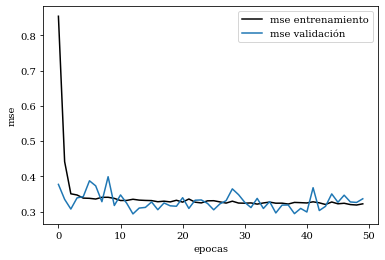

In [53]:
plt.plot(lstm_model.history.history['mean_squared_error'], color='k', label = 'mse entrenamiento')
plt.plot(lstm_model.history.history['val_mean_squared_error'], label = 'mse validación')
plt.ylabel('mse')
plt.xlabel('epocas')
plt.legend(loc='best')
plt.savefig(ruta_imagenes+'LSTM_cal_val_mse.png', bbox_inches='tight', dpi=150)

In [114]:
# pd.DataFrame(index=names, data = predicciones).to_csv('predicciones.csv')

In [115]:
# pd.DataFrame(index=names, data = scores).to_csv('scores.csv')

# Leer los datos

In [ ]:
# names = list(pd.read_csv('scores.csv', index_col=0).index)
# scores = list(pd.read_csv('scores.csv', index_col=0).values)
# predicciones = list(pd.read_csv('predicciones.csv', index_col=0).values)

### scores

In [56]:
df_scores = pd.DataFrame(index=names, data = scores, columns=['r2', 'mse'])

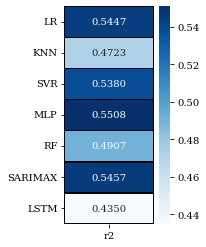

In [67]:
# r2
plt.figure(figsize=(2,4))
sns.heatmap(pd.DataFrame(df_scores['r2']), annot=True,  fmt='.4f', cbar=True, linecolor='black', linewidths=0.7,cmap=plt.cm.Blues)
plt.savefig(ruta_imagenes+'r2_anomalias.png', bbox_inches='tight', dpi=150)

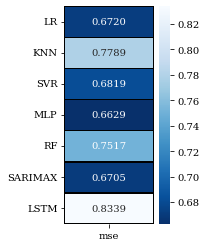

In [69]:
# mse
plt.figure(figsize=(2,4))
sns.heatmap(pd.DataFrame(df_scores['mse']), annot=True,  fmt='.4f', cbar=True, linecolor='black', linewidths=0.7,cmap=plt.cm.Blues_r)
plt.savefig(ruta_imagenes+'mse_anomalias.png', bbox_inches='tight', dpi=150)

### Analisis de ganancia respecto a la climatología

In [70]:
def serie_climatologica(climatologia, fecha_inicio, fecha_fin):

    serie_clima = pd.Series(index=pd.date_range(fecha_inicio, fecha_fin, freq='D'))
    for mes in range(1, 13):
        for dia in range(1,32):
            try:
                serie_clima[(serie_clima.index.month == mes)&(serie_clima.index.day == dia)] = climatologia[mes, dia]
            except:
                pass
#                 print(mes, dia)
    return serie_clima

In [71]:
media_climatologica = pd.read_csv(ruta_datos+'Media_clima_datos.csv', index_col=[0,1])
std_climatologica = pd.read_csv(ruta_datos+'Std_clima_datos.csv', index_col=[0,1])

In [72]:
serie_clima = serie_climatologica(media_climatologica['Caudal'], y_test.index[0], y_test.index[-1])
serie_std   = serie_climatologica(std_climatologica['Caudal'], y_test.index[0], y_test.index[-1])

In [73]:
df_predicciones = pd.DataFrame(index=pd.DatetimeIndex(y_test.index), data = np.transpose(predicciones), columns=names)

In [92]:
df_predicciones_series = df_predicciones.multiply(serie_std, axis=0).add(serie_clima, axis=0)

In [95]:
# df_predicciones_series

In [94]:
# serie original
serie_caudal_test = y_test*serie_std+serie_clima

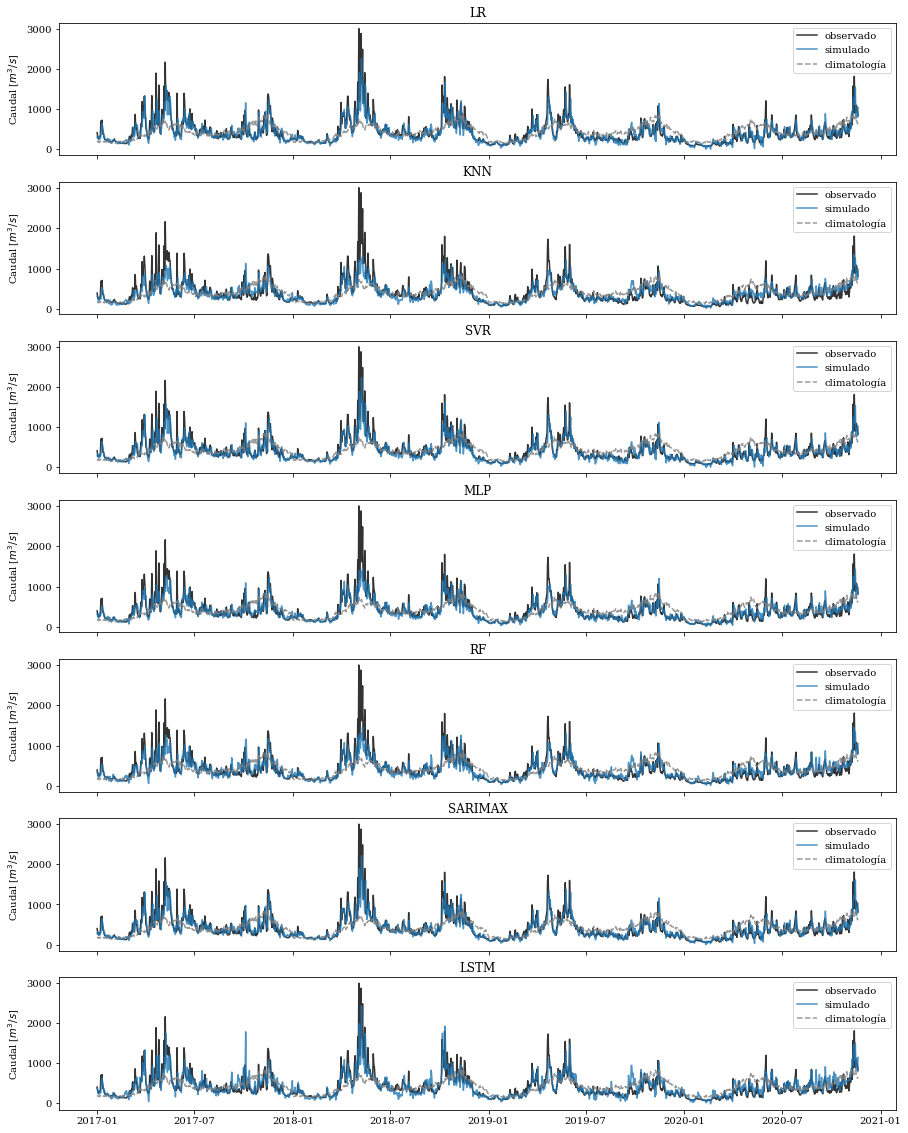

In [108]:
fig, axs = plt.subplots(len(df_predicciones_series.keys()), figsize=(15,20), sharex=True)

for i, modelo in enumerate(df_predicciones_series.keys()):
    
    serie_caudal_pron = df_predicciones_series[modelo]

    axs[i].plot(serie_caudal_test, alpha = 0.8, color = 'k', label='observado')
    axs[i].plot(serie_caudal_pron, alpha = 0.8, label='simulado')
    axs[i].plot(serie_clima, alpha = 0.8, color = 'gray', ls='--',label='climatología')
    axs[i].set_title(modelo)
    axs[i].set_ylabel('Caudal [$m^3/s$]')
    
    axs[i].legend(loc='best');
    
plt.savefig(ruta_imagenes+'pronosticos_series_modelos.png', bbox_inches='tight', dpi=150)

In [109]:
datos = pd.read_csv(ruta_datos+'Datos.csv', index_col=0, parse_dates=True)
datos = datos.iloc[~datos.isna().any(axis=1).values,:]

datos_train = datos[:f_train]
datos_test  = datos[f_test:]

caudal_antes = datos_test['Caudal_antes']

## Skill score

In [111]:
def SS(skill_pron, skill_ref):
    return np.round((1-skill_pron/skill_ref)*100, 2)

In [110]:
squared = True

# Referencia
clima_rmse = mean_squared_error(serie_caudal_test, serie_clima, squared=squared) # False para RMSE
caudal_antes_rmse = mean_squared_error(serie_caudal_test, caudal_antes, squared=squared) # False para RMSE

In [118]:
names_modelos = []
scores_modelos_series = []

for i, modelo in enumerate(df_predicciones_series.keys()):
    
    serie_caudal_pron = df_predicciones_series[modelo]
    
    pron_rmse  = mean_squared_error(serie_caudal_test, serie_caudal_pron, squared=squared) # False para RMSE
    SS_pron_clima = SS(pron_rmse, clima_rmse)
    SS_pron_antes = SS(pron_rmse, caudal_antes_rmse)
    
    scores_modelos_series.append([pron_rmse, SS_pron_clima, SS_pron_antes])
    names_modelos.append(modelo)

In [119]:
df_scores_modelos = pd.DataFrame(index=names_modelos, data= scores_modelos_series, columns=['mse', 'SS_clima', 'SS_antes'])

In [120]:
df_scores_modelos

,mse,SS_clima,SS_antes
LR,36068.802455,49.90,12.11
KNN,40044.462388,44.38,2.43
SVR,36532.183111,49.26,10.98
MLP,35289.343118,50.98,14.01
RF,39189.586341,45.57,4.51
SARIMAX,35940.299719,50.08,12.43
LSTM,43981.995918,38.91,-7.17


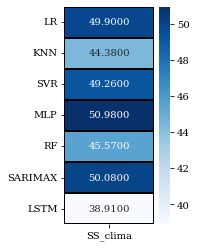

In [122]:
# SS_clima
plt.figure(figsize=(2,4))
sns.heatmap(pd.DataFrame(df_scores_modelos['SS_clima']), annot=True,  fmt='.4f', cbar=True, linecolor='black', linewidths=0.7,cmap=plt.cm.Blues)
plt.savefig(ruta_imagenes+'SS_CLIMA.png', bbox_inches='tight', dpi=150)

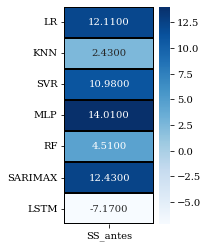

In [123]:
# SS_antes
plt.figure(figsize=(2,4))
sns.heatmap(pd.DataFrame(df_scores_modelos['SS_antes']), annot=True,  fmt='.4f', cbar=True, linecolor='black', linewidths=0.7,cmap=plt.cm.Blues)
plt.savefig(ruta_imagenes+'SS_ANTES.png', bbox_inches='tight', dpi=150)

In [125]:
# caudal antes repecto a la climatología
SS_antes_clima = SS(caudal_antes_rmse, clima_rmse)
print(SS_antes_clima)

43.0


# Prueba de descomposición estacional

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose data
decomposition = seasonal_decompose(serie_caudal_test, period=365)

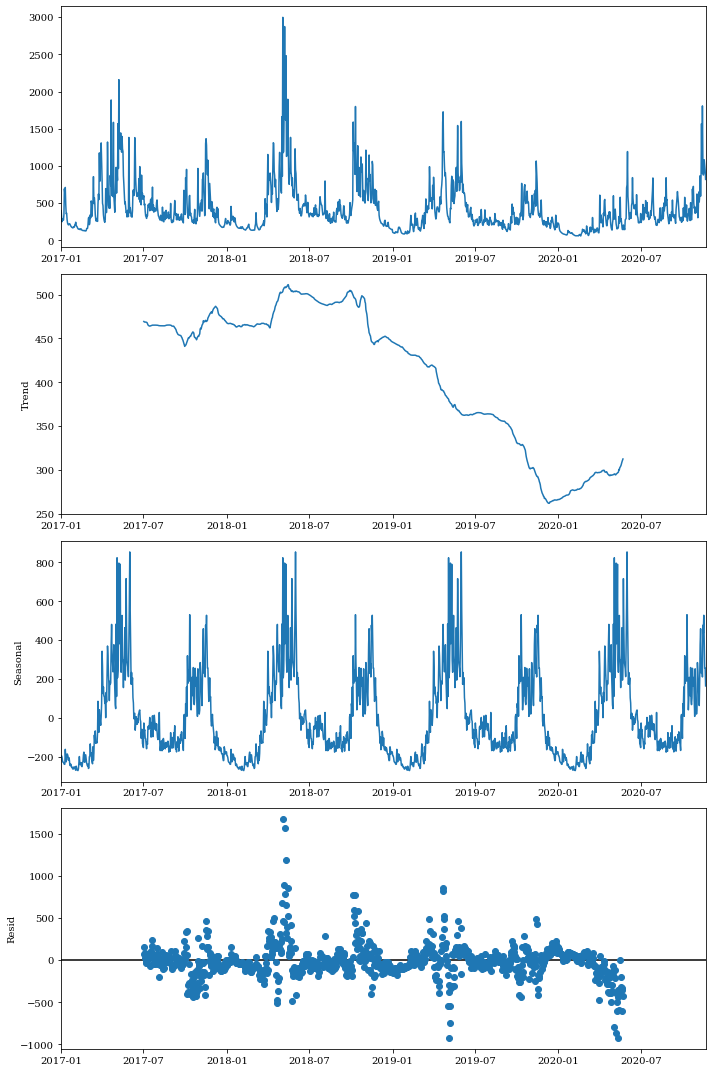

In [84]:
# Plot decomposed data
decomposition.plot()
plt.show()

# Estacionariedad

-4.325289408495161
0.00040148968545739515


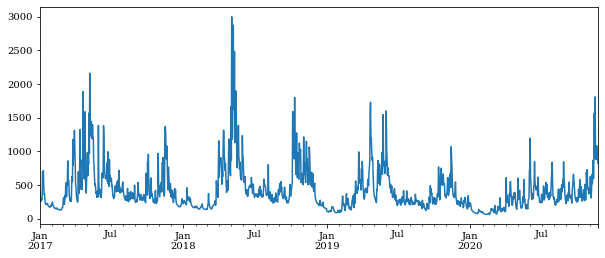

In [114]:
from statsmodels.tsa.stattools import adfuller

plt.figure(figsize=(10,4))

results = adfuller(serie_caudal_test)
print(results[0]) # print ADF statistic
print(results[1]) # print the p-value 
serie_caudal_test.plot();

<AxesSubplot:>

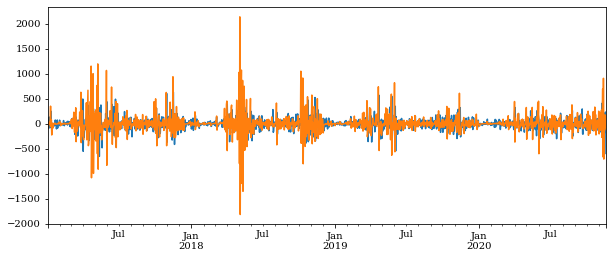

In [113]:
plt.figure(figsize=(10,4))
dji_log=serie_caudal_pron.diff(1)
dji_log2=serie_caudal_test.diff(1)
dji_log=dji_log.dropna()
dji_log2=dji_log2.dropna()
dji_log.plot()
dji_log2.plot()

In [115]:
# Import the acf module and the plot_acf module from statsmodels
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

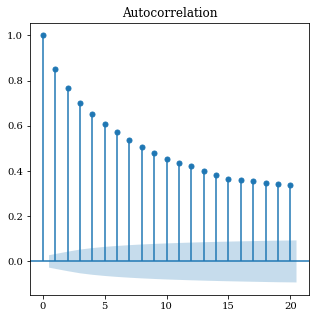

In [124]:
# Plot the acf function
plot_acf(y_train, lags=20, alpha=0.05)
plt.show()

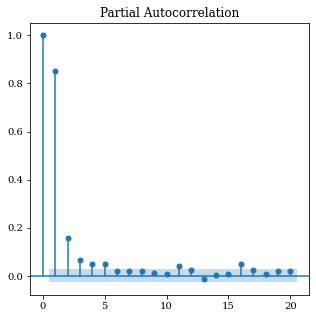

In [129]:
# Plot the acf function
plot_pacf(y_train, lags=20, alpha=0.05)
plt.show()

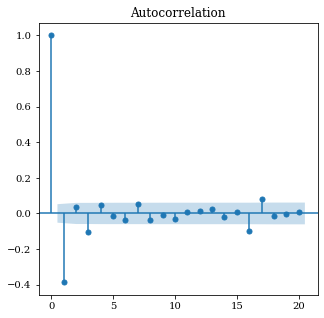

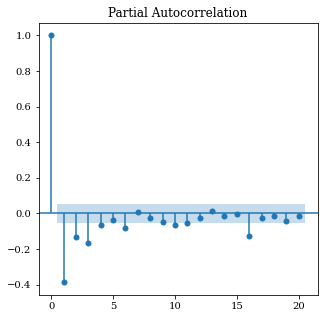

In [131]:
plot_acf(dji_log2, lags=20, alpha=0.05)
plt.show()

plot_pacf(dji_log2, lags=20, alpha=0.05)
plt.show()